# Tensor Decomposition 실습
이번 시간에는 간단한 convolution filter에 CP, Tucker decomposition을 적용하여, 실제로 이미지에 해당 필터를 통과시켰을때, 결과가 동일하게 나오는가를 실습해봅니다.

결과를 미리 언급하자면, rank를 어떻게 설정하는가에 따라서 동일 결과가 나오기도, 나오지 않기도 합니다.

이 실습 코드를 가지고 학습한 후, 왜 이런 결과가 나오는지 추가적인 연구를 해보아도 좋습니다! 

In [ ]:
!pip install tensorly 
!pip install ptflops

     |████████████████████████████████| 198 kB 5.2 MB/s 
     |████████████████████████████████| 154 kB 50.1 MB/s 
  Created wheel for ptflops: filename=ptflops-0.6.6-py3-none-any.whl size=8903 sha256=1a5b0134b356389ee1bf0526564b7994c770b3422335e27aa2c7920699e1b723
  Stored in directory: /root/.cache/pip/wheels/eb/7c/e5/2332373fcac1b39ba9eb95698ac370da3e14eaba5516e22721
Successfully built ptflops


## 0. Import libraries

In [ ]:
import numpy as np
import tensorly as tl
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.decomposition import parafac, tucker
from ptflops import get_model_complexity_info
import torch
import torch.nn as nn
import warnings
from torch.autograd import Variable
import matplotlib.pyplot as plt
import copy

warnings.filterwarnings("ignore")

# switch to the PyTorch backend
tl.set_backend('pytorch')

# fix the random seed to make things consistent
np.random.seed(42)

## 1. 함수 정의
  1. run_layer: conv 필터와 이미지를 입력으로 받아, macs와 convolution output을 출력해줌
  2. show_results: 각 결과 이미지의 min, max 픽셀 값과 결과를 stack하여 보여줌
  3. get_mse: 원 convolution 출력값과 decomposed convolution의 출력값의 mse를 계산할때 활용 

In [ ]:
def run_layer(layer: nn.Module, img: torch.Tensor) -> np.ndarray:
  """Run image onto layer."""
  with torch.no_grad():
    passed = layer(img_tensor)
  # calculate macs
  macs, params = get_model_complexity_info(layer, tuple([1, 5000, 5000]), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))
  return passed.numpy()

def show_results(img: np.ndarray):
  """Show results"""
  n = img.shape[1]
  for i in range(n):
    print(f"fmap:{i} max: {np.max(img[0][i])}, min: {np.min(img[0][i])}")
  stack_img = np.concatenate([img[0][i] for i in range(n)], 0)
  cv2_imshow(stack_img)

def get_mse(src, tgt) -> float:
  """Calc mse."""
  if isinstance(src, torch.Tensor):
    return torch.mean((src - tgt)**2)
  elif isinstance(src, np.ndarray):
    return np.mean((src - tgt)**2)

## 이미지 준비

In [ ]:
# Download image; change if you want to try other image
!wget https://i.ibb.co/WgYtP9c/mandu.png

--2021-05-19 12:57:22--  https://i.ibb.co/WgYtP9c/mandu.png
Resolving i.ibb.co (i.ibb.co)... 172.96.140.18, 104.194.8.196
Connecting to i.ibb.co (i.ibb.co)|172.96.140.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40594 (40K) [image/png]
Saving to: ‘mandu.png’

mandu.png           100%[===================>]  39.64K  --.-KB/s    in 0.09s   

2021-05-19 12:57:23 (450 KB/s) - ‘mandu.png’ saved [40594/40594]



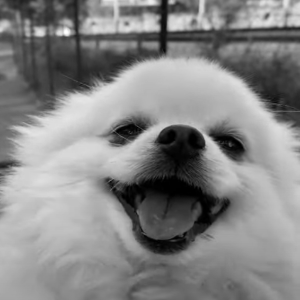

(300, 300)


In [ ]:
# Show Image
import cv2
from google.colab.patches import cv2_imshow
im = cv2.imread("mandu.png")
im = cv2.resize(im, dsize=(300, 300))
gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_im)
print(gray_im.shape)

## 4. 실습용 Conv weights 설정
Reference: https://setosa.io/ev/image-kernels/

실습에 사용할 filter weights는 이미 잘 알려진 hand crafted filter들을 사용합니다. 

In [ ]:
# Define conv weights
weights = np.zeros((4, 3, 3)) # shape = [5, 3, 5]
# ch 0: blur
weights[0] = np.array([[0.0625, 0.125, 0.0625],[0.125, 0.25, 0.125],[0.0625, 0.125, 0.0625]])
# ch 1: sharpen
weights[1] = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
# ch 2: outline
weights[2] = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]])
# ch 3: emboss
weights[3] = np.array([[-2, -1, 0],[-1, 1, 1],[0, 1, 2]])

weights = np.expand_dims(weights, 1)
print('X')
print(weights)
print('X:',weights.shape)S

X
[[[[ 0.0625  0.125   0.0625]
   [ 0.125   0.25    0.125 ]
   [ 0.0625  0.125   0.0625]]]


 [[[ 0.     -1.      0.    ]
   [-1.      5.     -1.    ]
   [ 0.     -1.      0.    ]]]


 [[[-1.     -1.     -1.    ]
   [-1.      8.     -1.    ]
   [-1.     -1.     -1.    ]]]


 [[[-2.     -1.      0.    ]
   [-1.      1.      1.    ]
   [ 0.      1.      2.    ]]]]
X: (4, 1, 3, 3)


### Set conv layer
가져온 필터값을 conv2d torch module의 weight으로 설정합니다.

In [ ]:
weights_tensor = Variable(tl.tensor(weights), requires_grad=False)
conv = nn.Conv2d(
    in_channels=1,
    out_channels=4,
    kernel_size=3,
    stride=1,
    bias=False)
# [out, in, h, w]
print(conv.weight.shape)
conv.weight = torch.nn.Parameter(weights_tensor)
print(conv.weight)

torch.Size([4, 1, 3, 3])
Parameter containing:
tensor([[[[ 0.0625,  0.1250,  0.0625],
          [ 0.1250,  0.2500,  0.1250],
          [ 0.0625,  0.1250,  0.0625]]],


        [[[ 0.0000, -1.0000,  0.0000],
          [-1.0000,  5.0000, -1.0000],
          [ 0.0000, -1.0000,  0.0000]]],


        [[[-1.0000, -1.0000, -1.0000],
          [-1.0000,  8.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000]]],


        [[[-2.0000, -1.0000,  0.0000],
          [-1.0000,  1.0000,  1.0000],
          [ 0.0000,  1.0000,  2.0000]]]], requires_grad=True)


### Apply conv on sample image
예시 이미지에 convolution을 적용해 결과를 확인합니다.

tensor([[[[ 97.,  95.,  91.,  ..., 145., 148., 154.],
          [102.,  99.,  95.,  ..., 153., 160., 170.],
          [102.,  99.,  94.,  ..., 170., 180., 190.],
          ...,
          [164., 164., 164.,  ..., 145., 145., 145.],
          [164., 164., 164.,  ..., 145., 145., 145.],
          [163., 163., 163.,  ..., 144., 145., 145.]]]])
torch.Size([1, 1, 300, 300])
Conv2d(0.0 M, 100.000% Params, 0.899 GMac, 100.000% MACs, 1, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
Computational complexity:       0.9 GMac
Number of parameters:           36      
fmap:0 max: 252.375, min: 0.0
fmap:1 max: 295.0, min: -115.0
fmap:2 max: 359.0, min: -276.0
fmap:3 max: 603.0, min: -424.0


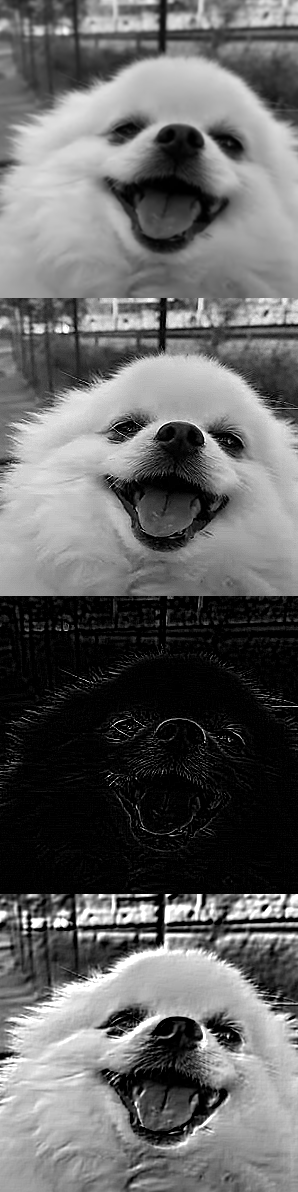

In [ ]:
img_tensor = torch.Tensor(gray_im).unsqueeze(0).unsqueeze(0)
print(img_tensor)
print(img_tensor.shape)
result_img = run_layer(conv, img_tensor)
show_results(result_img)

## 5. CP decomposition sandbox
CP decomposition을 weight tensor에 적용해보는 예시는 아래와 같습니다.

reference: http://tensorly.org/stable/auto_examples/decomposition/plot_image_compression.html#sphx-glr-auto-examples-decomposition-plot-image-compression-py

In [ ]:
# Perform the CP decomposition
weights, factors = parafac(tensor=weights_tensor, rank=2)
# Reconstruct the weights_tensor from the factors
cp_reconstruction = tl.cp_to_tensor((weights, factors))
print('Original', weights_tensor)
print(f'weights: {weights}')
print(f'factors: {factors}')
print('CP recon', cp_reconstruction)
print('MSE', get_mse(cp_reconstruction, weights_tensor))

Original tensor([[[[ 0.0625,  0.1250,  0.0625],
          [ 0.1250,  0.2500,  0.1250],
          [ 0.0625,  0.1250,  0.0625]]],


        [[[ 0.0000, -1.0000,  0.0000],
          [-1.0000,  5.0000, -1.0000],
          [ 0.0000, -1.0000,  0.0000]]],


        [[[-1.0000, -1.0000, -1.0000],
          [-1.0000,  8.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000]]],


        [[[-2.0000, -1.0000,  0.0000],
          [-1.0000,  1.0000,  1.0000],
          [ 0.0000,  1.0000,  2.0000]]]])
weights: tensor([1., 1.])
factors: [tensor([[ 0.1714,  0.9970],
        [ 5.2764, -3.0397],
        [ 8.2106, -6.7543],
        [ 0.7216, 13.7348]]), tensor([[-1.0000,  0.1560]]), tensor([[-0.1253,  0.0278],
        [ 0.9971,  0.4697],
        [-0.0775,  0.9668]]), tensor([[ 0.1253,  0.0277],
        [-0.9974,  0.4693],
        [ 0.0775,  0.9658]])]
CP recon tensor([[[[ 2.8113e-03, -1.9386e-02,  5.8484e-03],
          [-1.9397e-02,  2.0476e-01,  5.7315e-02],
          [ 5.8294e-03,  5.7311e-02,  1.4627e

## 6. Tucker decomposition sandbox

Tucker decomposition을 weight tensor에 적용해보는 예시는 아래와 같습니다.

reference: http://tensorly.org/stable/auto_examples/decomposition/plot_image_compression.html#sphx-glr-auto-examples-decomposition-plot-image-compression-py

In [ ]:
# Tucker decomposition
core, tucker_factors = tucker(weights_tensor, rank=2)
# Reconstruct the weights_tensor from the core, factors
tucker_reconstruction = tl.tucker_to_tensor((core, tucker_factors))
print('Original', weights_tensor)
print(f'core: {core}')
print(f'tucker_factors: {tucker_factors}')
print('Tucker recon', tucker_reconstruction)
print('MSE', torch.mean((tucker_reconstruction - weights_tensor)**2))

Original tensor([[[[ 0.0625,  0.1250,  0.0625],
          [ 0.1250,  0.2500,  0.1250],
          [ 0.0625,  0.1250,  0.0625]]],


        [[[ 0.0000, -1.0000,  0.0000],
          [-1.0000,  5.0000, -1.0000],
          [ 0.0000, -1.0000,  0.0000]]],


        [[[-1.0000, -1.0000, -1.0000],
          [-1.0000,  8.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000]]],


        [[[-2.0000, -1.0000,  0.0000],
          [-1.0000,  1.0000,  1.0000],
          [ 0.0000,  1.0000,  2.0000]]]])
core: tensor([[[[ 9.8153, -0.0852],
          [-0.0852, -2.0328]]],


        [[[ 0.2042,  0.5742],
          [ 0.5742,  0.9497]]]])
tucker_factors: [tensor([[-0.0148,  0.0020],
        [-0.5264, -0.8294],
        [-0.8428,  0.4805],
        [-0.1111,  0.2850]]), tensor([[1.]]), tensor([[-0.1325, -0.8052],
        [ 0.9849, -0.1723],
        [-0.1111, -0.5674]]), tensor([[ 0.1325,  0.8052],
        [-0.9849,  0.1723],
        [ 0.1111,  0.5674]])]
Tucker recon tensor([[[[-1.8625e-02, -2.1438e-02, -1.281

## 7. Apply Tensor Decomposition onto Conv layer

CP와 Tucker-2 decomposition을 Torch Conv layer에 적용하는 함수입니다.

Reference: https://github.com/jacobgil/pytorch-tensor-decompositions/blob/master/decompositions.py

In [ ]:
# Helper function
# https://github.com/jacobgil/pytorch-tensor-decompositions/blob/master/decompositions.py

import tensorly as tl
from tensorly.decomposition import parafac, partial_tucker
import numpy as np
import torch
import torch.nn as nn

def cp_decomposition_conv_layer(layer, rank):
    """ Gets a conv layer and a target rank, 
        returns a nn.Sequential object with the decomposition """

    # Perform CP decomposition on the layer weight tensorly. 
    _, factors = \
        parafac(layer.weight.data, rank=rank, normalize_factors=False)
    last, first, vertical, horizontal = factors

    pointwise_s_to_r_layer = torch.nn.Conv2d(in_channels=first.shape[0], \
            out_channels=first.shape[1], kernel_size=1, stride=1, padding=0, 
            dilation=layer.dilation, bias=False)

    depthwise_vertical_layer = torch.nn.Conv2d(in_channels=vertical.shape[1], 
            out_channels=vertical.shape[1], kernel_size=(vertical.shape[0], 1),
            stride=1, padding=(layer.padding[0], 0), dilation=layer.dilation,
            groups=vertical.shape[1], bias=False)

    depthwise_horizontal_layer = \
        torch.nn.Conv2d(in_channels=horizontal.shape[1], \
            out_channels=horizontal.shape[1], 
            kernel_size=(1, horizontal.shape[0]), stride=layer.stride,
            padding=(0, layer.padding[0]), 
            dilation=layer.dilation, groups=horizontal.shape[1], bias=False)

    pointwise_r_to_t_layer = torch.nn.Conv2d(in_channels=last.shape[1], \
            out_channels=last.shape[0], kernel_size=1, stride=1,
            padding=0, dilation=layer.dilation, bias=True)

    if layer.bias:
      pointwise_r_to_t_layer.bias.data = layer.bias.data

    depthwise_horizontal_layer.weight.data = \
        torch.transpose(horizontal, 1, 0).unsqueeze(1).unsqueeze(1)
    depthwise_vertical_layer.weight.data = \
        torch.transpose(vertical, 1, 0).unsqueeze(1).unsqueeze(-1)
    pointwise_s_to_r_layer.weight.data = \
        torch.transpose(first, 1, 0).unsqueeze(-1).unsqueeze(-1)
    pointwise_r_to_t_layer.weight.data = last.unsqueeze(-1).unsqueeze(-1)

    new_layers = [pointwise_s_to_r_layer, depthwise_vertical_layer, \
                    depthwise_horizontal_layer, pointwise_r_to_t_layer]
    
    return nn.Sequential(*new_layers)

def tucker_decomposition_conv_layer(layer, rank=3):
    """ Gets a conv layer, 
        returns a nn.Sequential object with the Tucker decomposition.
    """
    core, [last, first] = \
        partial_tucker(layer.weight.data, \
            modes=[0, 1], n_iter_max=2000000, rank=rank, init='svd')

    # A pointwise convolution that reduces the channels from S to R3
    first_layer = torch.nn.Conv2d(in_channels=first.shape[0], \
            out_channels=first.shape[1], kernel_size=1,
            stride=1, padding=0, dilation=layer.dilation, bias=False)

    # A regular 2D convolution layer with R3 input channels 
    # and R3 output channels
    core_layer = torch.nn.Conv2d(in_channels=core.shape[1], \
            out_channels=core.shape[0], kernel_size=layer.kernel_size,
            stride=layer.stride, padding=layer.padding, dilation=layer.dilation,
            bias=False)

    # A pointwise convolution that increases the channels from R4 to T
    last_layer = torch.nn.Conv2d(in_channels=last.shape[1], \
        out_channels=last.shape[0], kernel_size=1, stride=1,
        padding=0, dilation=layer.dilation, bias=True)

    if layer.bias:
      last_layer.bias.data = layer.bias.data

    first_layer.weight.data = \
        torch.transpose(first, 1, 0).unsqueeze(-1).unsqueeze(-1)
    last_layer.weight.data = last.unsqueeze(-1).unsqueeze(-1)
    core_layer.weight.data = core

    new_layers = [first_layer, core_layer, last_layer]
    return nn.Sequential(*new_layers)

### CP decomposition

CP decomposition의 rank 크기에 따른 결과

#### Rank1

Sequential(
  0.0 M, 100.000% Params, 0.375 GMac, 100.000% MACs, 
  (0): Conv2d(0.0 M, 6.667% Params, 0.025 GMac, 6.671% MACs, 1, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): Conv2d(0.0 M, 20.000% Params, 0.075 GMac, 20.005% MACs, 1, 1, kernel_size=(3, 1), stride=(1, 1), bias=False)
  (2): Conv2d(0.0 M, 20.000% Params, 0.075 GMac, 19.997% MACs, 1, 1, kernel_size=(1, 3), stride=(1, 1), bias=False)
  (3): Conv2d(0.0 M, 53.333% Params, 0.2 GMac, 53.326% MACs, 1, 4, kernel_size=(1, 1), stride=(1, 1))
)
Computational complexity:       0.37 GMac
Number of parameters:           15      
fmap:0 max: 27.981796264648438, min: -1.321054220199585
fmap:1 max: 771.6763305664062, min: -56.50628662109375
fmap:2 max: 1187.166748046875, min: -85.93272399902344
fmap:3 max: 143.55734252929688, min: -11.243124008178711


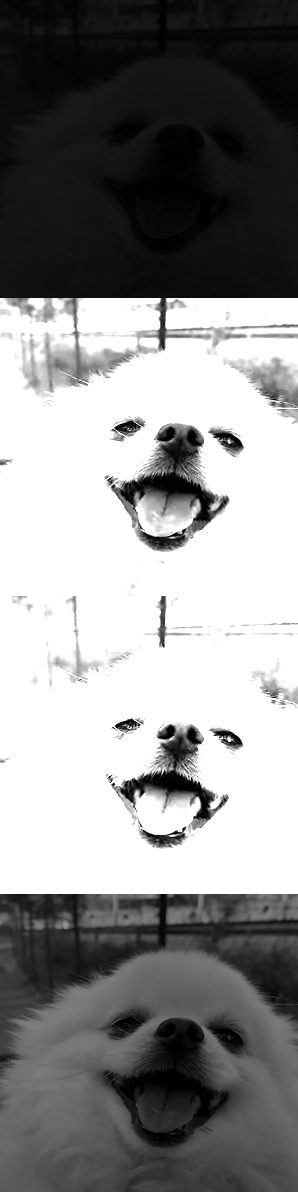

Feature_map mse 138902.77


In [ ]:
cp_sequential_rank1=cp_decomposition_conv_layer(layer=conv, rank=1)
rank1_img = run_layer(cp_sequential_rank1, img_tensor)
show_results(rank1_img)
print("Feature_map mse", get_mse(result_img, rank1_img))

#### Rank 2

Sequential(
  0.0 M, 100.000% Params, 0.65 GMac, 100.000% MACs, 
  (0): Conv2d(0.0 M, 7.692% Params, 0.05 GMac, 7.697% MACs, 1, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): Conv2d(0.0 M, 23.077% Params, 0.15 GMac, 23.083% MACs, 2, 2, kernel_size=(3, 1), stride=(1, 1), groups=2, bias=False)
  (2): Conv2d(0.0 M, 23.077% Params, 0.15 GMac, 23.073% MACs, 2, 2, kernel_size=(1, 3), stride=(1, 1), groups=2, bias=False)
  (3): Conv2d(0.0 M, 46.154% Params, 0.3 GMac, 46.147% MACs, 2, 4, kernel_size=(1, 1), stride=(1, 1))
)
Computational complexity:       0.65 GMac
Number of parameters:           26      
fmap:0 max: 112.1466293334961, min: -0.6517132520675659
fmap:1 max: 601.283935546875, min: -71.38884735107422
fmap:2 max: 802.6392211914062, min: -124.7160415649414
fmap:3 max: 1285.953369140625, min: -0.6235659122467041


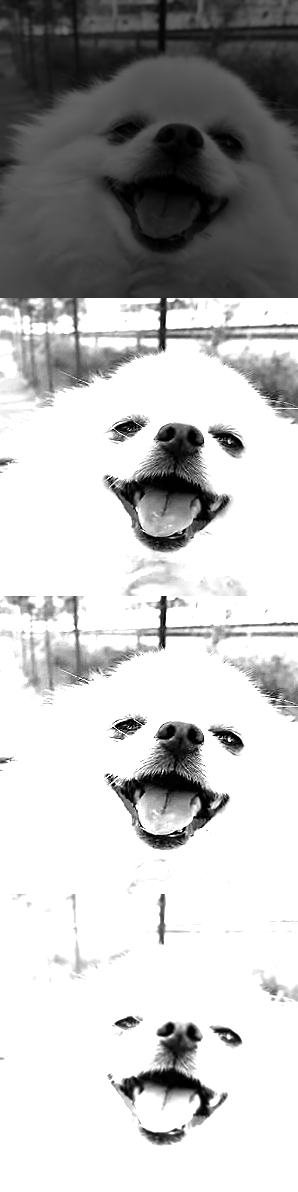

Feature_map mse 142400.19


In [ ]:
cp_sequential_rank2=cp_decomposition_conv_layer(layer=conv, rank=2)
rank2_img = run_layer(cp_sequential_rank2, img_tensor)
show_results(rank2_img)
print("Feature_map mse", get_mse(result_img, rank2_img))

#### Rank 3

Sequential(
  0.0 M, 100.000% Params, 0.924 GMac, 100.000% MACs, 
  (0): Conv2d(0.0 M, 8.108% Params, 0.075 GMac, 8.113% MACs, 1, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): Conv2d(0.0 M, 24.324% Params, 0.225 GMac, 24.330% MACs, 3, 3, kernel_size=(3, 1), stride=(1, 1), groups=3, bias=False)
  (2): Conv2d(0.0 M, 24.324% Params, 0.225 GMac, 24.320% MACs, 3, 3, kernel_size=(1, 3), stride=(1, 1), groups=3, bias=False)
  (3): Conv2d(0.0 M, 43.243% Params, 0.4 GMac, 43.236% MACs, 3, 4, kernel_size=(1, 1), stride=(1, 1))
)
Computational complexity:       0.92 GMac
Number of parameters:           37      
fmap:0 max: 249.22862243652344, min: 0.3500800132751465
fmap:1 max: 334.3254699707031, min: -101.95487976074219
fmap:2 max: 357.4952697753906, min: -275.8778381347656
fmap:3 max: 600.5260009765625, min: -419.8607177734375


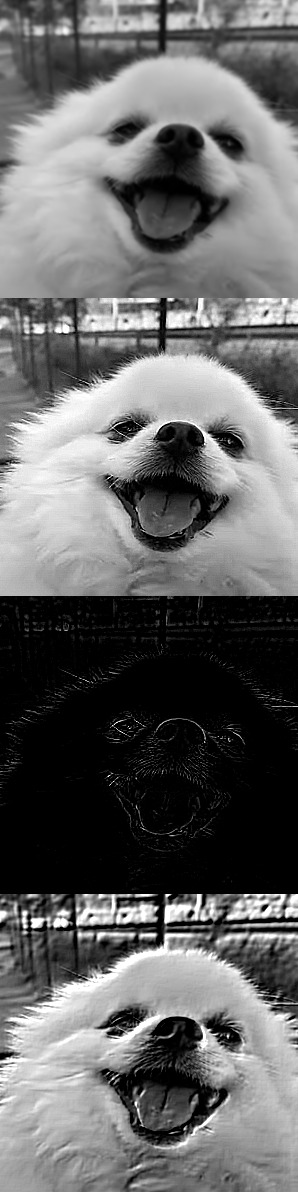

Feature_map mse 100.87771


In [ ]:
cp_sequential_rank3=cp_decomposition_conv_layer(layer=conv, rank=3)
rank3_img = run_layer(cp_sequential_rank3, img_tensor)
show_results(rank3_img)
print("Feature_map mse", get_mse(result_img, rank3_img))

#### Rank 4

Sequential(
  0.0 M, 100.000% Params, 1.199 GMac, 100.000% MACs, 
  (0): Conv2d(0.0 M, 8.333% Params, 0.1 GMac, 8.339% MACs, 1, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): Conv2d(0.0 M, 25.000% Params, 0.3 GMac, 25.006% MACs, 4, 4, kernel_size=(3, 1), stride=(1, 1), groups=4, bias=False)
  (2): Conv2d(0.0 M, 25.000% Params, 0.3 GMac, 24.996% MACs, 4, 4, kernel_size=(1, 3), stride=(1, 1), groups=4, bias=False)
  (3): Conv2d(0.0 M, 41.667% Params, 0.5 GMac, 41.660% MACs, 4, 4, kernel_size=(1, 1), stride=(1, 1))
)
Computational complexity:       1.2 GMac
Number of parameters:           48      
fmap:0 max: 245.10877990722656, min: 0.03146880865097046
fmap:1 max: 295.54071044921875, min: -114.74357604980469
fmap:2 max: 358.2466125488281, min: -276.41473388671875
fmap:3 max: 602.5913696289062, min: -424.3857727050781


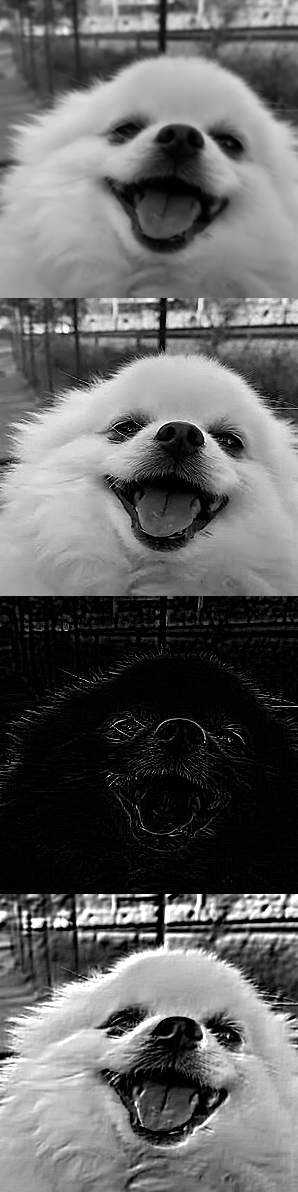

Feature_map mse 4.7685103


In [ ]:
cp_sequential_rank4=cp_decomposition_conv_layer(layer=conv, rank=4)
rank4_img = run_layer(cp_sequential_rank4, img_tensor)
show_results(rank4_img)
print("Feature_map mse", get_mse(result_img, rank4_img))

### Tucker Decomposition
Tucker decomposition의 rank 크기에 따른 결과



#### Rank 1

Sequential(
  0.0 M, 100.000% Params, 0.45 GMac, 100.000% MACs, 
  (0): Conv2d(0.0 M, 5.556% Params, 0.025 GMac, 5.560% MACs, 1, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): Conv2d(0.0 M, 50.000% Params, 0.225 GMac, 49.998% MACs, 1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (2): Conv2d(0.0 M, 44.444% Params, 0.2 GMac, 44.442% MACs, 1, 4, kernel_size=(1, 1), stride=(1, 1))
)
Computational complexity:       0.45 GMac
Number of parameters:           18      
fmap:0 max: 6.359915256500244, min: -4.832440376281738
fmap:1 max: 241.36683654785156, min: -159.4183807373047
fmap:2 max: 384.9214172363281, min: -256.9888610839844
fmap:3 max: 49.7499885559082, min: -31.862842559814453


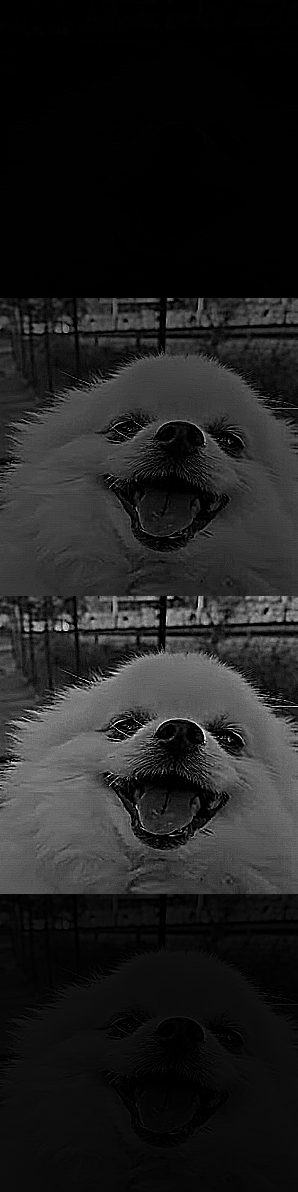

Feature_map mse 14225.276


In [ ]:
tucker_sequential_rank1=tucker_decomposition_conv_layer(layer=conv, rank=1)
rank1_img = run_layer(tucker_sequential_rank1, img_tensor)
show_results(rank1_img)
print("Feature_map mse", get_mse(result_img, rank1_img))

#### Rank 2

Sequential(
  0.0 M, 100.000% Params, 0.774 GMac, 100.000% MACs, 
  (0): Conv2d(0.0 M, 3.226% Params, 0.025 GMac, 3.228% MACs, 1, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): Conv2d(0.0 M, 58.065% Params, 0.45 GMac, 58.063% MACs, 1, 2, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (2): Conv2d(0.0 M, 38.710% Params, 0.3 GMac, 38.709% MACs, 2, 4, kernel_size=(1, 1), stride=(1, 1))
)
Computational complexity:       0.77 GMac
Number of parameters:           31      
fmap:0 max: 8.193286895751953, min: -7.303022384643555
fmap:1 max: 244.251220703125, min: -147.3527069091797
fmap:2 max: 390.5574951171875, min: -236.52734375
fmap:3 max: 603.9010009765625, min: -423.2182922363281


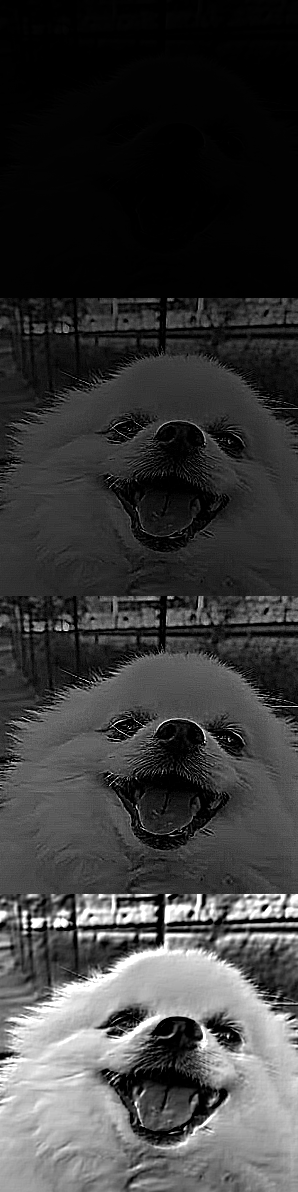

Feature_map mse 8910.346


In [ ]:
tucker_sequential_rank2=tucker_decomposition_conv_layer(layer=conv, rank=2)
rank2_img = run_layer(tucker_sequential_rank2, img_tensor)
show_results(rank2_img)
print("Feature_map mse", get_mse(result_img, rank2_img))

#### Rank 3

Sequential(
  0.0 M, 100.000% Params, 1.099 GMac, 100.000% MACs, 
  (0): Conv2d(0.0 M, 2.273% Params, 0.025 GMac, 2.275% MACs, 1, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): Conv2d(0.0 M, 61.364% Params, 0.674 GMac, 61.363% MACs, 1, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (2): Conv2d(0.0 M, 36.364% Params, 0.4 GMac, 36.363% MACs, 3, 4, kernel_size=(1, 1), stride=(1, 1))
)
Computational complexity:       1.1 GMac
Number of parameters:           44      
fmap:0 max: 7.192907810211182, min: -8.415495872497559
fmap:1 max: 293.3010559082031, min: -115.67613220214844
fmap:2 max: 360.69927978515625, min: -274.0335693359375
fmap:3 max: 603.88720703125, min: -423.2299499511719


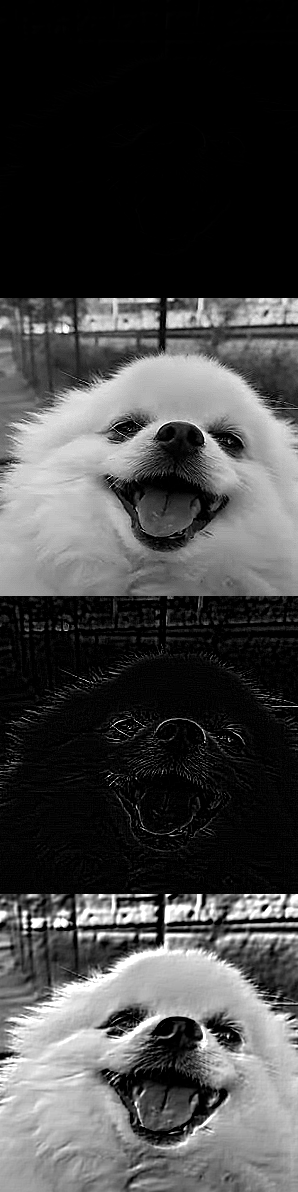

Feature_map mse 5273.076


In [ ]:
tucker_sequential_rank3 = tucker_decomposition_conv_layer(layer=conv, rank=3)
rank3_img = run_layer(tucker_sequential_rank3, img_tensor)
show_results(rank3_img)
print("Feature_map mse", get_mse(result_img, rank3_img))

#### Rank 4

Sequential(
  0.0 M, 100.000% Params, 1.424 GMac, 100.000% MACs, 
  (0): Conv2d(0.0 M, 1.754% Params, 0.025 GMac, 1.756% MACs, 1, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): Conv2d(0.0 M, 63.158% Params, 0.899 GMac, 63.157% MACs, 1, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (2): Conv2d(0.0 M, 35.088% Params, 0.5 GMac, 35.087% MACs, 4, 4, kernel_size=(1, 1), stride=(1, 1))
)
Computational complexity:       1.42 GMac
Number of parameters:           57      
fmap:0 max: 252.5919647216797, min: 0.21685469150543213
fmap:1 max: 295.0845031738281, min: -114.91529846191406
fmap:2 max: 358.96527099609375, min: -276.0345458984375
fmap:3 max: 602.6052856445312, min: -424.39459228515625


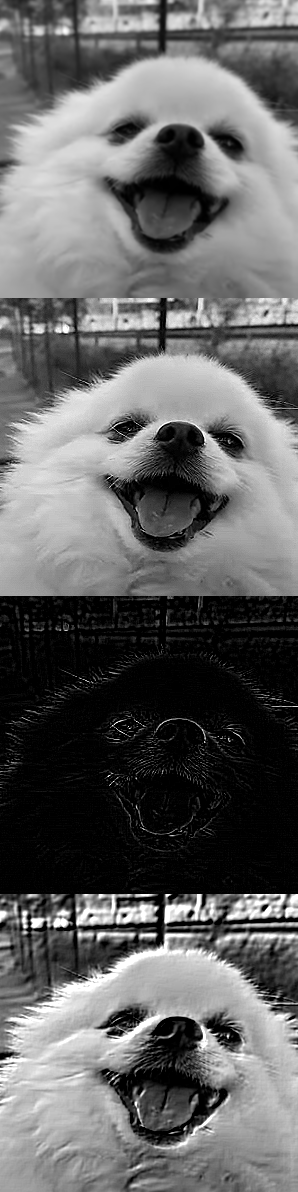

Feature_map mse 0.05279164


In [ ]:
tucker_sequential_rank4=tucker_decomposition_conv_layer(layer=conv, rank=4)
rank4_img = run_layer(tucker_sequential_rank4, img_tensor)
show_results(rank4_img)
print("Feature_map mse", get_mse(result_img, rank4_img))